<a href="https://colab.research.google.com/github/Steriva/MfM_Assignment/blob/main/extra_PK_pySINDy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pysindy

In [ ]:
!apt install texlive-fonts-recommended texlive-fonts-extra cm-super dvipng

# Loading the data and initial plots
In this section the data are loaded and plotted over time to see their trend.

In [116]:
import numpy as np
import pandas as pd
import pysindy as ps
from matplotlib import rcParams
import matplotlib.pyplot as plt
from google.colab import files
from sklearn.linear_model import Lasso


rcParams['figure.figsize'] = [16, 10]
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "serif"
})

rcParams['text.latex.preamble'] = [r'\usepackage{amssymb,amsmath,amsthm, mathtools}']

# Point Kinetics equations
\begin{equation}
\left\{
\begin{split}
\frac{\partial P}{\partial t} &= \frac{\rho-\beta}{\Lambda}P+\lambda c\\
\frac{\partial c}{\partial t} &= \frac{\beta}{\Lambda}P-\lambda c
\end{split}
\right.
\end{equation}

In [126]:
from scipy import integrate

beta = 730e-5
Lambda = 6e-5

li=np.array([0.0124,0.0305,0.111,0.301,1.14,3.01]);
bi=beta*np.array([0.033,0.219,0.196,0.395,0.115,0.042]);

lambda_prec=1/(sum(bi/li)/beta);

rho = 0.5 * beta

dt = 1e-4
T = 0.25
t = np.arange(0, T+dt, dt)

IC = np.array([1, beta / lambda_prec / Lambda])


def PK(P_c, t0, beta=beta, Lambda=Lambda, rho=rho, lambda_prec = lambda_prec):
  P, c = P_c
  return [(rho - beta) / Lambda * P + lambda_prec * c, beta / Lambda * P  - lambda_prec * c]

x_t = np.asarray([integrate.odeint(PK, IC, t)])

P, c = x_t[0,:,:].T

# plt.figure()
# plt.subplot(1,2,1), plt.plot(t,P)
# plt.subplot(1,2,2), plt.plot(t,c / IC[1])
# plt.show()

(P)' = -55.246 P + 120.397 c + -4.896 P*c
(c)' = -0.072 P + -0.009 c + 0.113 P*c


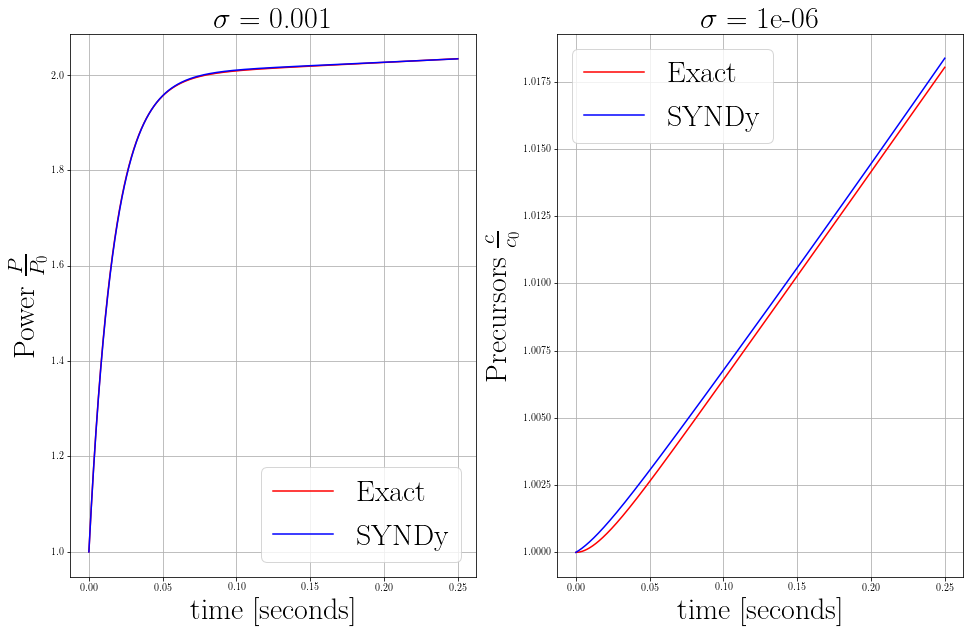

In [130]:
feature_names = ['P', 'c']

library_functions = [
    lambda x : x,
    lambda x,y : x * y
    ]
library_function_names = [
    lambda x : x,
    lambda x,y : x + '*' + y
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

polyLibrary = ps.PolynomialLibrary(degree = 2)

lasso_Pol_optimizer = Lasso(alpha=1, max_iter=4000, fit_intercept=False)
STLSQ_Pol_optimizer = ps.STLSQ(threshold=0.0001)

model = ps.SINDy(
    optimizer = STLSQ_Pol_optimizer,  
    feature_names = feature_names,
    differentiation_method = ps.SmoothedFiniteDifference(),
    feature_library = custom_library
)

# Fit pySINDy model
X = np.array([P, c/IC[1]]).T

stdNoisePower = 1e-3
stdNoisePrec = 1e-6
noiseAdd = np.array([np.random.normal(0,stdNoisePower,[len(t), 1]),
                     np.random.normal(0,stdNoisePrec, [len(t), 1])])


noiseAdd = np.reshape(noiseAdd, [len(t),2])

Xnoise = X + noiseAdd 

model.fit(Xnoise, t=t, ensemble=True, replace = False, quiet=False)
model.print()

sim = model.simulate([1, 1], t=t)


############################################################
import seaborn as sns
clrs = sns.color_palette("husl", 1)

fig1 = plt.figure()
plt.subplot(1,2,1)
plt.plot(t, X[:,0], "r-", label="Exact", markersize=8)
plt.fill_between(t, X[:,0]-stdNoisePower, X[:,0]+stdNoisePower, facecolor = clrs)
plt.plot(t, sim[:,0], "b-", label="SYNDy", markersize=8)
plt.xlabel("time [seconds]",fontsize=30)
plt.ylabel(r"Power $\frac{P}{P_0}$",fontsize=30)
plt.title( r"$\sigma = \;$" + str(stdNoisePower), fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=30)

plt.subplot(1,2,2)
plt.plot(t, X[:,1], "r-", label="Exact", markersize=8)
plt.fill_between(t, X[:,1]-stdNoisePrec, X[:,1]+stdNoisePrec, facecolor = clrs)
plt.plot(t, sim[:,1], "b-", label="SYNDy", markersize=8)
plt.xlabel("time [seconds]",fontsize=30)
plt.ylabel(r"Precursors $\frac{c}{c_0}$",fontsize=30)
plt.title( r"$\sigma = \;$" + str(stdNoisePrec), fontsize=30)
plt.grid(which='major',linestyle='-')
plt.grid(which='minor',linestyle='--')
plt.legend(fontsize=30)

plt.show()